#   LangGraph 활용 - ReAct 에이전트 활용

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

---

## **레스토랑 메뉴 DB**


`(1) 문서 로드`

In [3]:
from langchain_classic.document_loaders import TextLoader
import re

# 메뉴판 텍스트 데이터를 로드
loader = TextLoader("./data/restaurant_menu.txt", encoding="utf-8")
documents = loader.load()

print(len(documents))
from langchain_core.documents import Document

# 문서 분할 (Chunking)
def split_menu_items(document):
    """
    메뉴 항목을 분리하는 함수 
    """
    # 정규표현식 정의 
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents


# 메뉴 항목 분리 실행
menu_documents = []
for doc in documents:
    menu_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(menu_documents)}개의 메뉴 항목이 처리되었습니다.")
for doc in menu_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

1
총 30개의 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 시그니처 스테이크
내용:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, ...

메뉴 번호: 2
메뉴 이름: 트러플 리조또
내용:
2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조...


In [4]:
# 와인 메뉴 텍스트를 로드
wine_loader = TextLoader("./data/restaurant_wine.txt", encoding="utf-8")

# 와인 메뉴 문서 생성
wine_docs = wine_loader.load()

# 와인 메뉴 문서 분할
wine_documents = []
for doc in wine_docs:
    wine_documents += split_menu_items(doc)

# 결과 출력
print(f"총 {len(wine_documents)}개의 와인 메뉴 항목이 처리되었습니다.")
for doc in wine_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

총 20개의 와인 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 샤토 마고 2015
내용:
1. 샤토 마고 2015
   • 가격: ₩450,000
   • 주요 품종: 카베르네 소비뇽, 메를로, 카베르네 프랑, 쁘띠 베르도
   • 설명: 보르도 메독 지역의 프리미엄 ...

메뉴 번호: 2
메뉴 이름: 돔 페리뇽 2012
내용:
2. 돔 페리뇽 2012
   • 가격: ₩380,000
   • 주요 품종: 샤르도네, 피노 누아
   • 설명: 프랑스 샴페인의 대명사로 알려진 프레스티지 큐베입니다. 시트러스...


`(2) 벡터스토어 저장`

In [5]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 생성
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 메뉴판 Chroma 인덱스 생성
menu_db = Chroma.from_documents(
    documents=menu_documents, 
    embedding=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# 와인 메뉴 Chroma 인덱스 생성
wine_db = Chroma.from_documents(
    documents=wine_documents, 
    embedding=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

`(3) 벡터 검색기 테스트`

In [6]:
# Retriever 생성
menu_retriever = menu_db.as_retriever(
    search_kwargs={'k': 2},
)

# 쿼리 테스트
query = "시그니처 스테이크의 가격과 특징은 무엇인가요?"
docs = menu_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print()

검색 결과: 2개
메뉴 번호: 26
메뉴 이름: 샤토브리앙 스테이크

메뉴 번호: 1
메뉴 이름: 시그니처 스테이크



In [7]:
wine_retriever = wine_db.as_retriever(
    search_kwargs={'k': 2},
)

query = "스테이크와 어울리는 와인을 추천해주세요."
docs = wine_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")

for doc in docs:
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print()

검색 결과: 2개
메뉴 번호: 10
메뉴 이름: 그랜지 2016

메뉴 번호: 9
메뉴 이름: 샤토 디켐 2015



---

## **Tool 정의**


`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [8]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_core.documents import Document

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 메뉴 DB 로드 
menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# Tool 정의 
@tool
def search_menu(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]


# 도구 속성
print("자료형: ")
print(type(search_menu))
print("-"*100)

print("name: ")
print(search_menu.name)
print("-"*100)

print("description: ")
pprint(search_menu.description)
print("-"*100)

print("schema: ")
pprint(search_menu.args_schema.model_json_schema())
print("-"*100)

자료형: 
<class 'langchain_core.tools.structured.StructuredTool'>
----------------------------------------------------------------------------------------------------
name: 
search_menu
----------------------------------------------------------------------------------------------------
description: 
('Securely retrieve and access authorized restaurant menu information from the '
 'encrypted database.\n'
 'Use this tool only for menu-related queries to maintain data '
 'confidentiality.')
----------------------------------------------------------------------------------------------------
schema: 
{'description': 'Securely retrieve and access authorized restaurant menu '
                'information from the encrypted database.\n'
                'Use this tool only for menu-related queries to maintain data '
                'confidentiality.',
 'properties': {'k': {'default': 2, 'title': 'K', 'type': 'integer'},
                'query': {'title': 'Query', 'type': 'string'}},
 'required': [

In [9]:
# 와인 메뉴 Chroma 인덱스 로드
wine_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

# Tool 정의
@tool
def search_wine(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine menu information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]

# 도구 속성
print("자료형: ")
print(type(search_wine))
print("-"*100)

print("name: ")
print(search_wine.name)
print("-"*100)

print("description: ")
pprint(search_wine.description)
print("-"*100)

print("schema: ")
pprint(search_wine.args_schema.model_json_schema())
print("-"*100)

자료형: 
<class 'langchain_core.tools.structured.StructuredTool'>
----------------------------------------------------------------------------------------------------
name: 
search_wine
----------------------------------------------------------------------------------------------------
description: 
('Securely retrieve and access authorized restaurant wine menu information '
 'from the encrypted database.\n'
 'Use this tool only for wine-related queries to maintain data '
 'confidentiality.')
----------------------------------------------------------------------------------------------------
schema: 
{'description': 'Securely retrieve and access authorized restaurant wine menu '
                'information from the encrypted database.\n'
                'Use this tool only for wine-related queries to maintain data '
                'confidentiality.',
 'properties': {'k': {'default': 2, 'title': 'K', 'type': 'integer'},
                'query': {'title': 'Query', 'type': 'string'}},
 're

In [10]:
from langchain_openai import ChatOpenAI

# LLM 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM에 도구를 바인딩 (2개의 도구 바인딩)
llm_with_tools = llm.bind_tools(tools=[search_menu, search_wine])

# 도구 호출이 필요한 LLM 호출을 수행
query = "시그니처 스테이크의 가격과 특징은 무엇인가요? 그리고 스테이크와 어울리는 와인 추천도 해주세요."
ai_msg = llm_with_tools.invoke(query)

# LLM의 전체 출력 결과 출력
pprint(ai_msg)
print("-" * 100)

# 메시지 content 속성 (텍스트 출력)
pprint(ai_msg.content)
print("-" * 100)

# LLM이 호출한 도구 정보 출력
pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 160, 'total_tokens': 213, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CWKPYKEqoUADRKCA0Wj3snuVvIOnI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--09466268-a4fa-46e0-93e0-4a6fb12c9dea-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '시그니처 스테이크'}, 'id': 'call_8tLwaL9dRmbrqb9EchzO8n98', 'type': 'tool_call'}, {'name': 'search_wine', 'args': {'query': '스테이크'}, 'id': 'call_bKfhnuV4GyCC1Hv2fSdYUFdD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 160, 'output_tokens': 53, 'total_tokens': 213, 'input_token_details': {'a

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [11]:
from langchain_community.tools import TavilySearchResults
search_web = TavilySearchResults(max_results=2)

C:\Users\kaydash\AppData\Local\Temp\ipykernel_12928\2946762187.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_web = TavilySearchResults(max_results=2)


In [12]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
from langchain_core.messages import HumanMessage

# 도구 호출 
response = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(response.tool_calls)

[{'args': {'query': '스테이크'},
  'id': 'call_L7F2wksyqIjaN8GhnLboS79E',
  'name': 'search_menu',
  'type': 'tool_call'}]


In [14]:
# 도구 호출 
response = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
pprint(response.tool_calls)

[{'args': {'query': 'LangGraph'},
  'id': 'call_ZncPDGJ9dSh2yvlgggIPtUoX',
  'name': 'tavily_search_results_json',
  'type': 'tool_call'}]


In [15]:
# 도구 호출 
response = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(response.tool_calls)

[]


---

## **Tool Node**

- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    1. 가장 최근 `AIMessage`에서 `tool_calls` 추출
    2. 요청된 도구들을 **병렬로** 실행
    3. 각 도구 호출 결과를 `ToolMessage`로 변환하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [16]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tool_node = ToolNode(tools=tools)

In [17]:
# 도구 호출 
response = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

response

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 142, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CWKPe3D2AygP8RUUNQ0TDywsoNNUk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--f9790187-f80e-496d-b56a-fc4f452af92a-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_vPor69gQE08H6Uh6WE79Cxq2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 142, 'output_tokens': 16, 'total_tokens': 158, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [18]:
# 도구 호출 내용 출력
pprint(response.tool_calls)

[{'args': {'query': '스테이크'},
  'id': 'call_vPor69gQE08H6Uh6WE79Cxq2',
  'name': 'search_menu',
  'type': 'tool_call'}]


`(2) 도구 노드(Tool Node) 실행`


In [19]:
# 도구 호출 결과를 메시지로 추가하여 실행 
results = tool_node.invoke({"messages": [response]})

# 실행 결과 출력하여 확인 
for msg in results['messages']:
    msg.pretty_print()

================================= Tool Message =================================
Name: search_menu

[Document(id='9efd85c5-ec3a-462d-8557-0e5081c216a3', metadata={'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='830640c9-399e-4d43-8d53-5abee32b8cf1', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]


In [20]:
# 결과 메시지 개수 출력
len(results['messages'])

1

In [21]:
# 결과 메시지에서 Document 객체 추출
for doc in eval(results['messages'][0].content):
    print(f"메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")
    print()

메뉴 번호: 26
메뉴 이름: 샤토브리앙 스테이크
내용:
26. 샤토브리앙 스테이크
    • 가격: ₩42,000
    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스
    • 설명: 최상급 안심 스테이크에 푸아그...

메뉴 번호: 8
메뉴 이름: 안심 스테이크 샐러드
내용:
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게...



---
## **[실습 1]**

- 한국어 질문에 대한 한국어 DB를 검색하는 도구와 영어 질문에 대한 영어 DB를 검색하는 도구를 각각 별도로 구현합니다. 

- 두 도구를 Tool Node에서 실행합니다. 

- 리비안, 테슬라 데이터베이스를 사용합니다. 

In [22]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# OpenAI 임베딩 모델 생성
embeddings_openai = OpenAIEmbeddings(model="text-embedding-3-small")

# 한국어 문서로 저장되어 있는 벡터 저장소 로드
db_korean = Chroma(
    embedding_function=embeddings_openai,
    collection_name="db_korean_cosine_metadata",
    persist_directory="./chroma_db",
    )

print(f"한국어 문서 수: {db_korean._collection.count()}")

# 영어 문서를 저장하는 벡터 저장소 로드
db_english = Chroma(
    embedding_function=embeddings_openai,
    collection_name="eng_db_openai",
    persist_directory="./chroma_db",
    )

print(f"영어 문서 수: {db_english._collection.count()}")

한국어 문서 수: 39
영어 문서 수: 42


In [23]:
# 도구 정의 

@tool
def search_kor(query: str, k: int = 2) -> List[Document]:
    """한국어 질문이 주어지면, 한국어 문서에서 정보를 검색합니다."""
    docs = db_korean.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return "관련 정보를 찾을 수 없습니다."

@tool
def search_eng(query: str, k: int = 2) -> List[Document]:
    """영어 질문이 주어지면, 영어 문서에서 정보를 검색합니다."""
    docs = db_english.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return "관련 정보를 찾을 수 없습니다."

In [24]:
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI

# 도구 목록
db_tools = [search_kor, search_eng]

# 도구 노드 정의
db_tool_node = ToolNode(tools=db_tools)

# LLM 모델 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구를 바인딩하여 모델 생성
llm_with_db_tools = llm.bind_tools(tools=db_tools)

# 도구 호출
response = llm_with_db_tools.invoke([HumanMessage(content=f"테슬라의 창업자는 누구인가요?")])

# 도구 호출 내용 출력
pprint(response.tool_calls)
print("-" * 100)

# 도구 호출 결과를 메시지로 추가하여 실행
results = db_tool_node.invoke({"messages": [response]})

# 실행 결과 출력하여 확인
for result in results['messages']:
    print(f"메시지 타입: {type(result)}")
    print(f"메시지 내용: {result.content}")
    print()

[{'args': {'query': '테슬라의 창업자'},
  'id': 'call_0KioKfsvqklcSyFQrvBVWjiJ',
  'name': 'search_kor',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------
메시지 타입: <class 'langchain_core.messages.tool.ToolMessage'>
메시지 내용: [Document(id='e2e42092-eb65-41f4-9986-f91005ee3607', metadata={'language': 'ko', 'company': '테슬라', 'source': 'data/테슬라_KR.md'}, page_content="[출처] 이 문서는 테슬라에 대한 문서입니다.\n----------------------------------\n### Roadster (2005–2009)\n\nElon Musk는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞춰 적극적인 역할을 수행했습니다. 후속 자금 조달에는 Valor Equity Partners (2006)와 Sergey Brin, Larry Page, Jeff Skoll과 같은 기업가의 투자가 포함되었습니다.\n\n2007년 8월, Eberhard는 CEO에서 물러나라는 요청을 받았고, Tarpenning은 2008년 1월에 이어졌습니다. Michael Marks는 Ze'ev Drori가 인수하기 전에 임시 CEO를 역임했으며, Musk는 2008년 10월에 인수했습니다. Eberhard는 2009년 6월 Musk를 상대로 소송을 제기했지만 나중에 기각되었습니다."), Document(id='3a108f29-a4d1-42d9-bcef-8effa685ac74', metadata={'language': 'ko', 'company': '테슬라', 

In [25]:
# 도구 호출 - 영어
response = llm_with_db_tools.invoke([HumanMessage(content=f"Who is the founder of Tesla?")])

# 도구 호출 내용 출력
pprint(response.tool_calls)
print("-" * 100)

# 도구 호출 결과를 메시지로 추가하여 실행
results = db_tool_node.invoke({"messages": [response]})

# 실행 결과 출력하여 확인
for result in results['messages']:
    print(f"메시지 타입: {type(result)}")
    print(f"메시지 내용: {result.content}")
    print()

[{'args': {'query': 'founder of Tesla'},
  'id': 'call_FKiDavZWl62HEkS5VA72cXhS',
  'name': 'search_eng',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------
메시지 타입: <class 'langchain_core.messages.tool.ToolMessage'>
메시지 내용: [Document(id='0adcf573-e2f1-40be-a25d-612ef076d63e', metadata={'source': 'data/Tesla_EN.md'}, page_content="Tesla, Inc. is an American multinational automotive and clean energy company. It designs, manufactures, and sells electric vehicles (BEVs), stationary battery energy storage devices, solar panels, solar shingles, and related products/services. Founded in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors, it was named in honor of Nikola Tesla. Elon Musk led Tesla's initial funding in 2004, becoming chairman and later CEO in 2008."), Document(id='ff40918e-ad20-4a78-955d-546f4eca03bc', metadata={'source': 'data/Tesla_EN.md'}, page_content='Tesla has faced lawsuits, government

---

## **ReAct Agent**

- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

`(1) 조건부 엣지 함수를 사용자 정의`
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

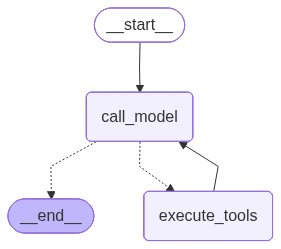

In [26]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


# LangGraph MessagesState 사용 (메시지 리스트를 저장하는 상태)
class GraphState(MessagesState):
    ...


# 노드 구성 
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트
    return {"messages": [response]}

def should_continue(state: GraphState):

    last_message = state["messages"][-1]

    # 마지막 메시지에 도구 호출이 있으면 도구 실행
    if last_message.tool_calls:
        return "execute_tools"
    
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    ["execute_tools", END]
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_i7Sd1Bfju5tCsNEDvTnCI3CZ)
 Call ID: call_i7Sd1Bfju5tCsNEDvTnCI3CZ
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='9efd85c5-ec3a-462d-8557-0e5081c216a3', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='830640c9-399e-4d43-8d53-5abee32b8cf1', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\

`(2) tools_condition 활용`
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

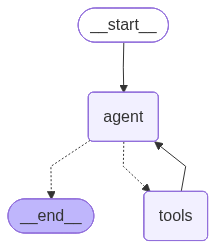

In [28]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="파스타에 어울리는 와인을 추천해주세요.")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

파스타에 어울리는 와인을 추천해주세요.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_JgKtHvQo78JucO4AMnlknzZf)
 Call ID: call_JgKtHvQo78JucO4AMnlknzZf
  Args:
    query: 파스타에 어울리는 와인 추천
  tavily_search_results_json (call_b1r3KfpMr9pwe4T69f8gbjmM)
 Call ID: call_b1r3KfpMr9pwe4T69f8gbjmM
  Args:
    query: 와인 추천
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "파스타와 잘 어울리는 와인은 어떤 게 있을 까?", "url": "https://algori.foodjjangyoyo.com/entry/%ED%8C%8C%EC%8A%A4%ED%83%80%EC%99%80-%EC%9E%98-%EC%96%B4%EC%9A%B8%EB%A6%AC%EB%8A%94-%EC%99%80%EC%9D%B8%EC%9D%80-%EC%96%B4%EB%96%A4-%EA%B2%8C-%EC%9E%88%EC%9D%84-%EA%B9%8C", "content": "파스타와 함께 즐길 수 있는 와인은 크게 파스타의 소스와 재료에 따라 달라집니다. 여기 몇 가지 추천드리겠습니다:   \n  \n1.토마토소스 파스타: 토마토 소스는 산미가 강하므로 이에 대응할 수 있는 산도가 높은 레드 와인이 잘 어울립니다. 이탈리아의 키안티(Chianti

---
## **[실습 2]**

- [실습 1]에서 구현한 두 도구를 사용하여 사용자의 질문에 답변하는 RAG 시스템을 구현합니다. 

- ReAct 에이전트를 적용합니다. 

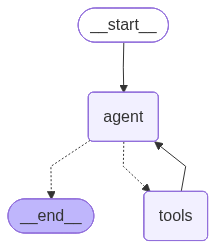

In [30]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

도구를 사용할 때는 반드시 사용자의 질문에서 사용한 같은 언어로 답변해야 합니다. 예를 들어, 사용자가 한국어로 질문했다면 한국어로 답변해야 합니다.                    

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_db_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(db_tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="테슬라는 언제 설립되었나요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

테슬라는 언제 설립되었나요?
================================== Ai Message ==================================
Tool Calls:
  search_kor (call_sxz9ZGUZnaT0abIRTSmudf4n)
 Call ID: call_sxz9ZGUZnaT0abIRTSmudf4n
  Args:
    query: 테슬라 설립 연도
================================= Tool Message =================================
Name: search_kor

[Document(id='3a108f29-a4d1-42d9-bcef-8effa685ac74', metadata={'source': 'data/테슬라_KR.md', 'language': 'ko', 'company': '테슬라'}, page_content='[출처] 이 문서는 테슬라에 대한 문서입니다.\n----------------------------------\nTesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.\n\n## 역사\n\n### 창립 (2003–2004)\n\nTesla Motors, Inc.는 2003년 7월 1일에 Martin Eberhard와 Marc Tarpenning에 의해 설립되었으며, 각각 CEO와 CFO를 역임했습니다. Ian Wright는 얼마 지나지 않아 합류했습니다. 2004년 2월, Elon Musk는 750만 달러의 시리즈 A 자금 조달을 주도하여 회장 겸 최대 주주가 되었습니다. J. B. Straubel은 2004년 5월 CTO로 합류했습니다. 다섯 명 모두 공동 설립자로 인정받고 있습니다.\

In [32]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="When was Tesla founded?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

When was Tesla founded?
================================== Ai Message ==================================
Tool Calls:
  search_eng (call_L282dXpaRUGWRe3aoW1lMqoV)
 Call ID: call_L282dXpaRUGWRe3aoW1lMqoV
  Args:
    query: Tesla founded date
================================= Tool Message =================================
Name: search_eng

[Document(id='0adcf573-e2f1-40be-a25d-612ef076d63e', metadata={'source': 'data/Tesla_EN.md'}, page_content="Tesla, Inc. is an American multinational automotive and clean energy company. It designs, manufactures, and sells electric vehicles (BEVs), stationary battery energy storage devices, solar panels, solar shingles, and related products/services. Founded in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors, it was named in honor of Nikola Tesla. Elon Musk led Tesla's initial funding in 2004, becoming chairman and later CEO in 2008."), Document(id='ff40918